# Week 7: Unsupervised learning.

In training models of genre and authorship, we've been using *supervised learning algorithms* (logistic regression and naive Bayes). These are basically strategies for learning by example; the researcher "supervises" the learning process by providing labeled examples of categories to be learned, and the algorithm models a boundary between the label(s).

But it is also possible to infer structure from data without labeling examples or specifying a particular category as an object of inquiry. This is *unsupervised learning*.

Playing around with unsupervised techniques can be a lot of fun. One often has the sense that unexpected patterns are being revealed. But interpreting these patterns is a bit risky. The assumptions that guide a supervised model are mostly out in the open, embodied in the labels we have assigned. 

An unsupervised model still has to make assumptions: there is no free lunch here! But the assumptions we have made may not be obvious; they're latent in the choices we make while representing data or tuning the algorithm.

For this reason I recommend using unsupervised models as evidence only with considerable caution. On the other hand, they can be extremely useful in the initial stages of exploring unfamiliar data. We'll try a few different approaches, and get a sense of how choices shape our results.

The unsupervised methods we will survey can be divided into two categories.

1. Those that produce continuous variables (methods of dimension-reduction). And
2. Those that produce discrete clusters.

### Loading data and creating numeric versions of categorical variables.

Let's start our exploration by loading the familiar poetry-fiction dataset. While we're doing that we'll import a few other modules that will be useful later.

We'll also create numeric columns that we can use later to set colors for data points.

In [223]:
%matplotlib inline
import os, csv
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# pd.options.mode.chained_assignment = None

from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import MDS

cwd = os.getcwd()
print('Current working directory: ' + cwd + '\n')
      
relativepath = os.path.join('..', 'data', 'weekfour', 'poefic.csv')
poefic = pd.read_csv(relativepath)

# let's make the date column numeric
poefic['date'] = pd.to_numeric(poefic['date'], errors='coerce')

# To make it easier to survey our results, we need to cut this dataset down to size.
# There are two paths we could take. We could select all the elite-reviewed volumes

elite = poefic.loc[poefic['reception'] == 'elite', : ].copy()
elite.reset_index(inplace = True)

# Then create a numeric column to separate poetry from fiction.
genreindices = []
for g in elite['genre']:
    if g == 'poetry':
        idx = 0
    else:
        idx = 1
    genreindices.append(idx)
elite['genreindices'] = genreindices
    

# Or select particular authors

authors =  ['Craik, Dinah Maria Mulock,', 'Browning, Elizabeth Barrett,', 'Browning, Robert,', 'Dickens, Charles,', 'James, Henry,', 'Hardy, Thomas,', 'Lowell, Amy,']
selected = poefic[poefic['author'].isin(authors)].copy()
selected.reset_index(inplace = True)

# and create a numeric column to identify them.
authindices = []
for a in selected['author']:
    idx = authors.index(a)
    authindices.append(idx)
selected['authindices'] = authindices

# Let's clear the original poefic variable in case you've got a memory crunch

del poefic


Current working directory: /Users/rdubnic2/Documents/lis590dsh/Code



In [224]:
selected.head()

,index,date,author,title,genre,reception,text,authindices
0,69,1874.0,"Hardy, Thomas,",Desperate remedies,fiction,elite,"should she not have written to you before ? "" ...",5
1,81,1909.0,"James, Henry,",The portrait of a lady,fiction,elite,"Mr. Osmond talked to Isabel, and Lord Warburto...",4
2,130,1877.0,"James, Henry,",The American,fiction,elite,"reason Madame de Cintre"" reconciled herself to...",4
3,160,1892.0,"Hardy, Thomas,",Tess of the D'Urbervilles,fiction,elite,towards her. ' Jump up 128 <pb> THE MAIDEN beh...,5
4,161,1892.0,"Hardy, Thomas,",Tess of the D'Urbervilles,fiction,elite,"improvised phlegm. ' Ah — and be ye! Well, I a...",5


### Creating term-document matrices

We will need to convert the text snippets in our dataframe into a term-document matrix. There are three different ways we can do this: a straightforward matrix of counts, a matrix normalized by tf-idf, and a matrix where each word column is centered and scaled to make all words equally important.

In [225]:
from sklearn.feature_extraction.text import CountVectorizer
# that will just give us a term-doc matrix

from sklearn.feature_extraction.text import TfidfTransformer
# normalizes by dividing each (document) row by row sum
# and then adjusts for inverse document frequency

from sklearn.preprocessing import StandardScaler
# normalizes by centering each column on its mean, and 
# dividing by standard deviation


countvec = CountVectorizer(max_features = 500)
# The number of features we're using is an important choice.

sparse_counts = countvec.fit_transform(selected['text'])

selected_termdoc = sparse_counts.toarray()
# a lot of these methods return a sparse matrix that needs to be
# reinflated with .toarray()

transformer = TfidfTransformer()
selected_tfidf = transformer.fit_transform(selected_termdoc).toarray()

normalizer = StandardScaler()
selected_normed = normalizer.fit_transform(selected_termdoc)


/Users/rdubnic2/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/rdubnic2/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Hey, what's in these matrices?

In their raw form, these are just matrices of numbers. The rows correspond to the document-rows of the original metadata matrix we read in. But the columns are not labeled. If you want to see what these contain, we need to add column labels from the CountVectorizer.

In [226]:
legible_tfidf = pd.DataFrame(selected_tfidf, columns=countvec.get_feature_names())
legible_tfidf.head()

,about,above,across,afraid,after,again,against,ago,air,all,...,wrong,ye,year,years,yes,yet,you,young,your,youth
0,0.010240,0.000000,0.000000,0.000000,0.035217,0.058695,0.019274,0.000000,0.000000,0.025768,...,0.000000,0.000000,0.000000,0.012916,0.031880,0.000000,0.112636,0.016909,0.012306,0.0
1,0.019654,0.000000,0.000000,0.039874,0.067597,0.033799,0.000000,0.000000,0.014466,0.008243,...,0.018498,0.000000,0.000000,0.000000,0.015298,0.009827,0.235854,0.000000,0.047243,0.0
2,0.008399,0.000000,0.000000,0.051116,0.000000,0.019257,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.013074,0.000000,0.235159,0.055473,0.050468,0.0
3,0.000000,0.000000,0.000000,0.000000,0.012055,0.000000,0.019792,0.018491,0.030957,0.026461,...,0.000000,0.019792,0.000000,0.000000,0.032737,0.010515,0.273386,0.017363,0.025274,0.0
4,0.010237,0.015069,0.038538,0.000000,0.046943,0.000000,0.000000,0.000000,0.015069,0.051522,...,0.019269,0.019269,0.038538,0.000000,0.111548,0.000000,0.194498,0.000000,0.000000,0.0


### Principal component analysis

Let's run PCA on all three of the matrices we created. We'll also color the dots by author. In an ideal world we'd have a nice legend where author names are paired directly with discrete colors. But that takes a bit of time to figure out, whereas Pyplot makes it straightforward to plot a continuous colorbar.

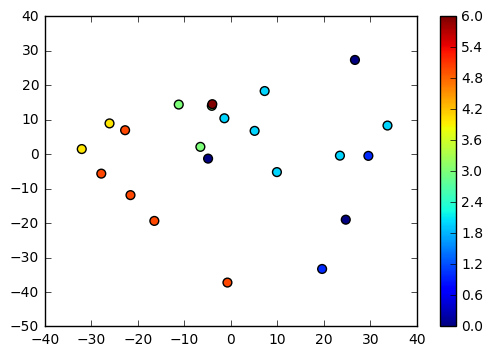

0: Craik, Dinah Maria Mulock,
1: Browning, Elizabeth Barrett,
2: Browning, Robert,
3: Dickens, Charles,
4: James, Henry,
5: Hardy, Thomas,
6: Lowell, Amy,


In [227]:
pca = PCA(n_components=2)
# Create a PCA-izer.

# First run it on the straight term-doc matrix. Note that this is actually 
# normalized a bit implicitly since all text snippets in this collection 
# run to 1200 words. Otherwise passage *lengths* could create differences,
# and you would need to divide rows by row-sums.

pca_termdoc = pca.fit_transform(selected_termdoc)
plot = plt.scatter(pca_termdoc[ : , 0], pca_termdoc[ : , 1], s = 40,
                   c = selected['authindices'], cmap = 'jet')
plt.colorbar(plot)
plt.show()
for index, name in enumerate(authors):
    print(str(index) + ": " + name)

#### What does this mean?

Are the volumes being arranged by author, by date of publication, or by genre?

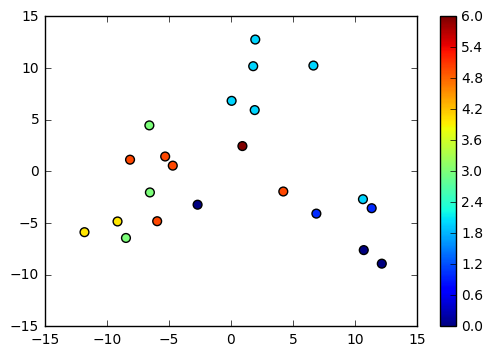

In [228]:
# Now let's try a version where all words are given equal weight, because
# columns are "normed" around a column mean.

pca = PCA(n_components=2)
pca_norm = pca.fit_transform(selected_normed)
plot = plt.scatter(pca_norm[ : , 0], pca_norm[ : , 1], s= 40, 
                   c = selected['authindices'], cmap = 'jet')
plt.colorbar(plot)
plt.show()

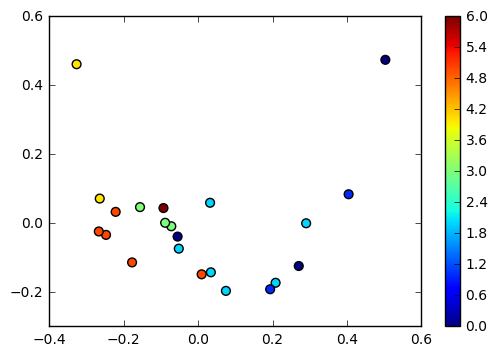

In [229]:
pca = PCA(n_components=2)
pca_tfidf = pca.fit_transform(selected_tfidf)
plot = plt.scatter(pca_tfidf[ : , 0], pca_tfidf[ : , 1], s= 40,
                   c = selected['authindices'], cmap = 'jet')
plt.colorbar(plot)
plt.show()

### Hierarchical clustering

We can also perform hierarchical clustering on any of those matrices, using the ```linkage``` and ```dendrogram``` functions we imported thus:

    from scipy.cluster.hierarchy import dendrogram, linkage
    
at the beginning of this notebook.

Some of the code below is adapted from Jörn Hees' very helpful blog:
https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

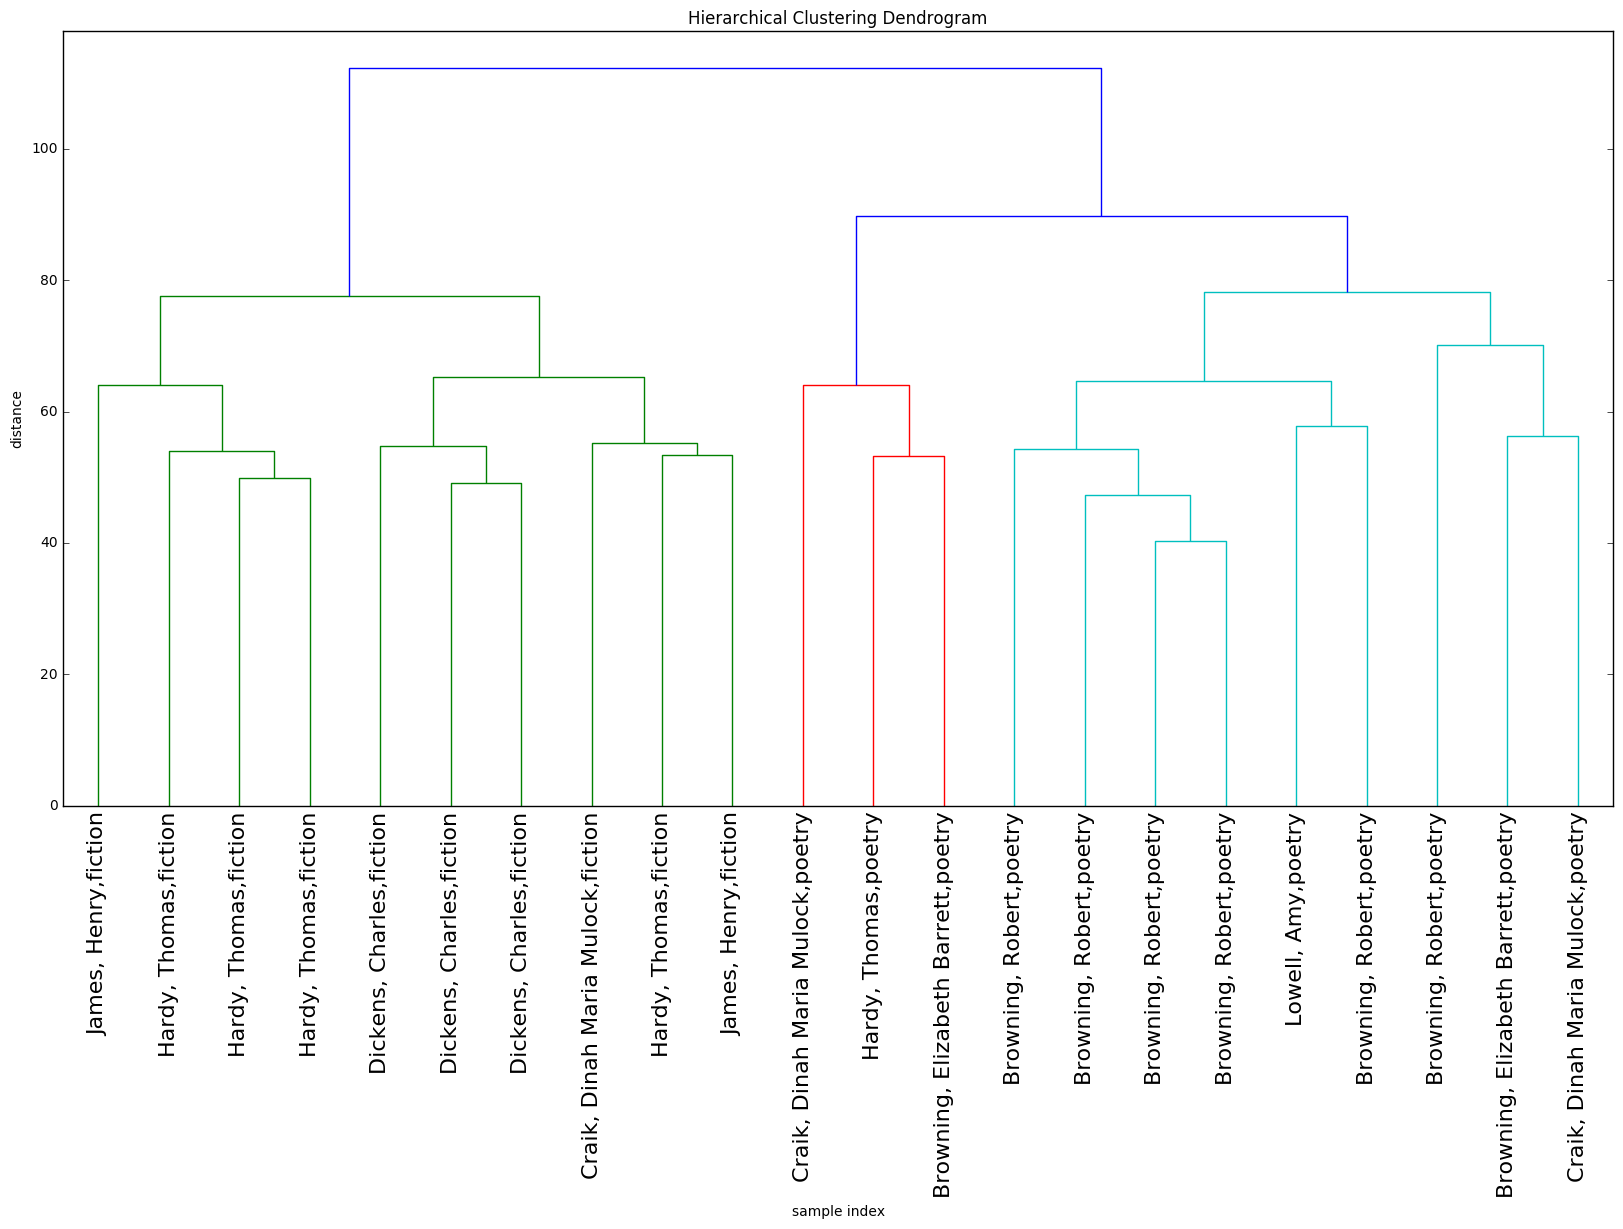

In [230]:
clustering = linkage(selected_termdoc, 'ward')
plt.figure(figsize=(20, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    clustering,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=16.,  # font size for the x axis labels
    labels = list(selected['author'] + selected['genre'])
)
plt.show()

### Changing number of features

Go back up to the section labeled **Creating term-document matrices** and change the number of features that the CountVectorizer allows. Try just 50, and then try 1000.

Does anything change? Look particularly at the hierarchical clustering.

### Applying these methods to the "elite" dataset

We've used PCA and hierarchical clustering to explore relations among a subset of six authors. Which was cool, but we've got a lot more data in the barn to work with!

At the beginning of this notebook, we created another, larger data frame called 'elite' that contained all the reviewed volumes in poefic, both poetry and fiction.

This is probably too many volumes to throw at a dendrogram. But see if you can get anything meaningful out of PCA. I'll get you started by creating the matrices we need.


In [231]:
# Code to create three matrices

elite_countvec = CountVectorizer(max_features = 500)
elite_termdoc = elite_countvec.fit_transform(elite['text']).toarray()
elite_tfidf = transformer.fit_transform(elite_termdoc).toarray()
elite_normed = normalizer.fit_transform(elite_termdoc)

/Users/rdubnic2/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/rdubnic2/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


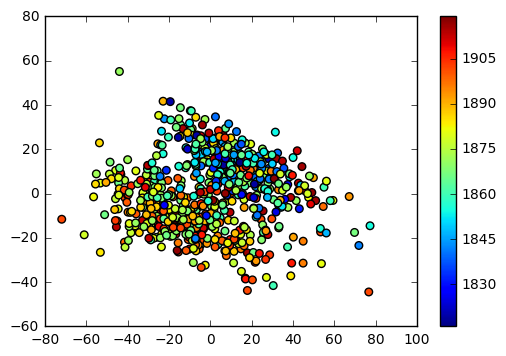

0: Craik, Dinah Maria Mulock,
1: Browning, Elizabeth Barrett,
2: Browning, Robert,
3: Dickens, Charles,
4: James, Henry,
5: Hardy, Thomas,
6: Lowell, Amy,


In [236]:
# Try running PCA on elite_termdoc and coloring the points by elite['date']
# the parameter s sets size; you might want to try 25 or 30 here
# the parameter c selects a vector to guide color
# cmap chooses a color map; you can try 'jet' or 'cool' or 'gray'

pca = PCA(n_components=2)
pca_tfidf = pca.fit_transform(elite_termdoc)
plot = plt.scatter(pca_tfidf[ : , 0], pca_tfidf[ : , 1], s= 30, c = elite['date'], cmap = 'jet')
plt.colorbar(plot)
plt.show()
for index, name in enumerate(authors):
    print(str(index) + ": " + name)

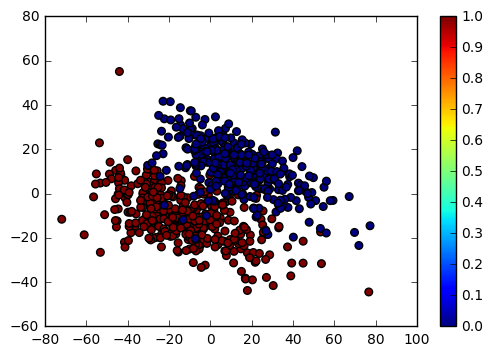

In [237]:
# Now try coloring the points by elite['genreindices'].

pca = PCA(n_components=2)
pca_tfidf = pca.fit_transform(elite_termdoc)
plot = plt.scatter(pca_tfidf[ : , 0], pca_tfidf[ : , 1], s= 30, c = elite['genreindices'], cmap = 'jet')
plt.colorbar(plot)
plt.show()

### Multidimensional scaling: does it improve anything?

On this dataset, it's not clear that it really does.

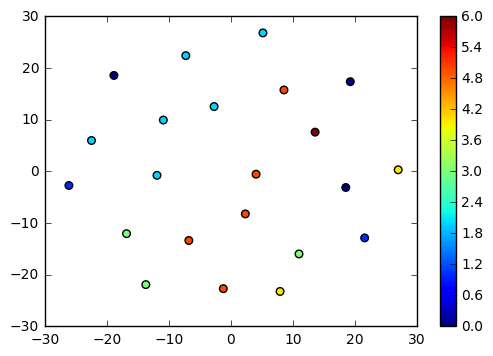

In [234]:
mds = MDS()
mds_matrix = mds.fit_transform(selected_normed)
plot = plt.scatter(mds_matrix[ : , 0], mds_matrix[ : , 1], 
                   s= 30, c = selected['authindices'], cmap = 'jet')
plt.colorbar(plot)
plt.show()